In [7]:
# !pip install keyboard
# !pip install xgboost
# !pip install mlxtend

<div style="color:white; background-color: #AEC6CF; padding: 20px; border-radius:8px; font-size:26px"><b style="font-weight: 700;"><center>Predicting Hotel Cancellations</center></b></div> 

<div style="color:white; background-color: #AEC6CF; padding: 20px; border-radius:8px; font-size:20px"><b style="font-weight: 700;"><center> Preprocessing and Modelling</center></b></div> 

This project is part of a competition released in DataCamp (https://app.datacamp.com/learn/competitions/predict-hotel-cancellation)

The dataset was collected from Kaggle (https://www.kaggle.com/datasets/ahsan81/hotel-reservations-classification-dataset) and modified accordingly

<div style="background-color:  #eddcd2; padding: 10px;">
    
### The Data

</div>

The bookings data is storaged in a file called `hotel_bookings.csv`, which contains the following:

| Column     | Description              |
|------------|--------------------------|
| `Booking_ID` | Unique identifier of the booking. |
| `no_of_adults` | The number of adults. |
| `no_of_children` | The number of children. |
| `no_of_weekend_nights` | Number of weekend nights (Saturday or Sunday). |
| `no_of_week_nights` | Number of week nights (Monday to Friday). |
| `type_of_meal_plan` | Type of meal plan included in the booking. |
| `required_car_parking_space` | Whether a car parking space is required. |
| `room_type_reserved` | The type of room reserved. |
| `lead_time` | Number of days before the arrival date the booking was made. |
| `arrival_year` | Year of arrival. |
| `arrival_month` | Month of arrival. |
| `arrival_date` | Date of the month for arrival. |
| `market_segment_type` | How the booking was made. |
| `repeated_guest` | Whether the guest has previously stayed at the hotel. |
| `no_of_previous_cancellations` | Number of previous cancellations. |
| `no_of_previous_bookings_not_canceled` | Number of previous bookings that were not canceled. |
| `avg_price_per_room` | Average price per day of the booking. |
| `no_of_special_requests` | Count of special requests made as part of the booking. |
| `booking_status` | Whether the booking was cancelled or not. |

<div style="background-color:  #eddcd2; padding: 10px;">
    
### Classification Problem

**Target**: booking_status
    
</div>

In [25]:
# Import the necessary libraries 

# EDA pkgs
import pandas as pd                         # for data manipulation and analysis 
import numpy as np                          # for working with arrays and matrices
pd.set_option('display.max_rows', 500)      # Set max number of rows displayed
pd.set_option('display.max_columns', 500)   # Set max number of columns displayed
pd.set_option('display.width', 1000)
import matplotlib.pyplot as plt             # for creating plots
%matplotlib inline

import seaborn as sns                       # for complex visualizations that can't be achieved by plt
sns.set(style="darkgrid");                  # Sets the default parameters for seaborn

# Preproccessing pkgs
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from imblearn.over_sampling import SMOTE

# Split pkgs
from sklearn.model_selection import train_test_split

# Avoid warnings
import warnings
warnings.filterwarnings('ignore')

# Create a stop pkg
# import keyboard             # <----------- does not work in jupyter notebook

<div style="background-color:  #ddedea; padding: 10px;">
    
### 1. Read Data 
    
</div>

In [2]:
# load the data
df = pd.read_csv("D:\git\Playground\Projects\Hotel Cancellations\hotel_bookings.csv", na_values=np.nan)
display(df.head(5))

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Not_Canceled
1,INN00002,2.0,0.0,2.0,3.0,Not Selected,0.0,Room_Type 1,5.0,2018.0,11.0,6.0,Online,0.0,0.0,0.0,106.68,1.0,Not_Canceled
2,INN00003,1.0,0.0,2.0,1.0,Meal Plan 1,0.0,Room_Type 1,1.0,2018.0,2.0,28.0,Online,0.0,0.0,0.0,60.00,0.0,Canceled
3,INN00004,2.0,0.0,0.0,2.0,Meal Plan 1,0.0,Room_Type 1,211.0,2018.0,5.0,20.0,Online,0.0,0.0,0.0,100.00,0.0,Canceled
4,INN00005,2.0,0.0,1.0,1.0,Not Selected,0.0,Room_Type 1,48.0,2018.0,4.0,11.0,Online,0.0,0.0,0.0,94.50,0.0,Canceled


In [3]:
df.dtypes

Booking_ID                               object
no_of_adults                            float64
no_of_children                          float64
no_of_weekend_nights                    float64
no_of_week_nights                       float64
type_of_meal_plan                        object
required_car_parking_space              float64
room_type_reserved                       object
lead_time                               float64
arrival_year                            float64
arrival_month                           float64
arrival_date                            float64
market_segment_type                      object
repeated_guest                          float64
no_of_previous_cancellations            float64
no_of_previous_bookings_not_canceled    float64
avg_price_per_room                      float64
no_of_special_requests                  float64
booking_status                           object
dtype: object

<div style="background-color:  #ddedea; padding: 10px;">
    
### 2. Wrangling Data 
    
</div>

In [4]:
# Change type of required_car_parking_space and repeated_guest

df['required_car_parking_space'] = df['required_car_parking_space'].astype('object')
df['repeated_guest'] = df['repeated_guest'].astype('object')

# -----------------------------------------------------------------------------------------------
# Correcting the wrong values in dates

# Unique values for the arrival_year
print(df['arrival_year'].value_counts())

# Checking for the maximum day per month in the data
print(df.groupby('arrival_month')['arrival_date'].agg('max'))

# Since neither 2017 nor 2018 are leap year, february has 28 days. 
df.loc[(df['arrival_month'] == 2) & (df['arrival_date'] >= 29), ['arrival_month','arrival_date']] = [3,1]

print(df.groupby('arrival_month')['arrival_date'].agg('max'))

# -----------------------------------------------------------------------------------------------
# Replace categories in 'required_car_parking_space' and 'repeated_guest' to avoid confusions

# 'required_car_parking_space'
df['required_car_parking_space'].replace(0, 'No', inplace = True)
df['required_car_parking_space'].replace(1, 'Yes', inplace = True)

# 'repeated_guest'
df['repeated_guest'].replace(0, 'No', inplace = True)
df['repeated_guest'].replace(1, 'Yes', inplace = True)

2018.0    29451
2017.0     6446
Name: arrival_year, dtype: int64
arrival_month
1.0     31.0
2.0     29.0
3.0     31.0
4.0     30.0
5.0     31.0
6.0     30.0
7.0     31.0
8.0     31.0
9.0     30.0
10.0    31.0
11.0    30.0
12.0    31.0
Name: arrival_date, dtype: float64
arrival_month
1.0     31.0
2.0     28.0
3.0     31.0
4.0     30.0
5.0     31.0
6.0     30.0
7.0     31.0
8.0     31.0
9.0     30.0
10.0    31.0
11.0    30.0
12.0    31.0
Name: arrival_date, dtype: float64


<div style="background-color:  #ddedea; padding: 10px;">
    
### 3. Cleaning Data 
    
</div> 

In [5]:
# Duplicates
print('Number of duplicates in the dataset: ', df.duplicated().sum())

Number of duplicates in the dataset:  0


In [6]:
# Drop the column 'Booking_ID' because is not relevant for any analysis
df = df.drop('Booking_ID', axis = 1)

df.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Not_Canceled
1,2.0,0.0,2.0,3.0,Not Selected,No,Room_Type 1,5.0,2018.0,11.0,6.0,Online,No,0.0,0.0,106.68,1.0,Not_Canceled
2,1.0,0.0,2.0,1.0,Meal Plan 1,No,Room_Type 1,1.0,2018.0,2.0,28.0,Online,No,0.0,0.0,60.00,0.0,Canceled
3,2.0,0.0,0.0,2.0,Meal Plan 1,No,Room_Type 1,211.0,2018.0,5.0,20.0,Online,No,0.0,0.0,100.00,0.0,Canceled
4,2.0,0.0,1.0,1.0,Not Selected,No,Room_Type 1,48.0,2018.0,4.0,11.0,Online,No,0.0,0.0,94.50,0.0,Canceled


In [7]:
# Missing Values
def summmissings(df):
    '''
    Function that shows the missing values per column in a dataframe df
    Input: df
    '''
    
    # Summary of missing values per features
    miss_num = df.isna().sum()

    miss_perc = round(miss_num/len(df)*100,1)

    df_miss =pd.DataFrame({'No_missing': miss_num,
                           '%_missing': miss_perc})

    print('Missing values summary per feature: \n')
    print('-------------------------------------------------------')
    display(df_miss)

In [8]:
# Apply function to show missing values
summmissings(df)

Missing values summary per feature: 

-------------------------------------------------------


,No_missing,%_missing
no_of_adults,413,1.1
no_of_children,324,0.9
no_of_weekend_nights,367,1.0
no_of_week_nights,807,2.2
type_of_meal_plan,526,1.5
required_car_parking_space,2592,7.1
room_type_reserved,1171,3.2
lead_time,472,1.3
arrival_year,378,1.0
arrival_month,504,1.4


In [9]:
# Create copy of dataset
df_copy = df.copy()

In [10]:
# numerical columns
cols_num = [col for col in df.columns if df[col].dtype != 'object']

# categorical columns
cols_cat = [col for col in df.columns if df[col].dtype == 'object']

In [11]:
# ==== KNN IMPUTATION TO NUMERIC FEATURES ====

# # Dealing with missing values
# def dealmissings(df):
    
# #     numerical columns
#     cols_num = [col for col in df.columns if df[col].dtype != 'object']
    
# #     Instantiate the model
#     knn_imp = KNNImputer(n_neighbors = 3) # the 3 most similar rows in the training data with no missing values in some columns
    
# #     categorical columns except 'type_of_meal_plan'
#     cols_cat = [col for col in df.columns if df[col].dtype == 'object']
    
# #     Instantiate the imputers
#     cat_imp = SimpleImputer(strategy = 'most_frequent')
    
# #     Instantiate Column Transformer
#     transformer = ColumnTransformer([('num_miss', knn_imp, cols_num),
#                                      ('cat_miss', cat_imp, cols_cat)],
#                                      remainder = 'passthrough')         # <-------- The remain columns keeps the same (none)
        
# #     Create dataframe with fitted and transformed data by the transformer 
#     df_clean = pd.DataFrame(transformer.fit_transform(df),
#                             columns = cols_num + cols_cat,
#                             index = df.index)
#     return df_clean

In [12]:
# ==== MICE IMPUTATION TO NUMERIC FEATURES ====

# Dealing with missing values
def dealmissings(df, cols_num, cols_cat):
    
#     Instantiate the MICE imputer
    mice_imp = IterativeImputer(random_state = 100,
                                max_iter = 10)        # <-------- if there are many missing values it is better to increase it
       
#     Instantiate the Simple imputer
    cat_imp = SimpleImputer(strategy = 'most_frequent')
    
#     Instantiate Column Transformer
    transformer = ColumnTransformer([('num_miss', mice_imp, cols_num),  # <-------- Apply MICE to numeric columns
                                     ('cat_miss', cat_imp, cols_cat)],  # <-------- Apply SimpleImputer to categorical columns
                                     remainder = 'passthrough')         # <-------- The remain columns keeps the same (none)
        
#     Create dataframe with fitted and transformed data by the transformer 
    df_clean = pd.DataFrame(transformer.fit_transform(df),
                            columns = cols_num + cols_cat,
                            index = df.index)
    
#     Change the data type of numeric columns, since the imputers changed them to object
    for col in cols_num:
        df_clean[col] = df_clean[col].astype('float')
    
#     print(df_clean.dtypes)
    
#     Round numerical columns, except 'avg_price_per_room'
    cols_int = [col for col in df.columns if df[col].dtype != 'object' and col != 'avg_price_per_room']
    df_clean[cols_int] = np.round(df_clean[cols_int])
    
    return df_clean

In [13]:
# Apply function for dealing with missing values

df_clean = dealmissings(df_copy, cols_num, cols_cat)
display(df_clean.head())

# ----------------------------------------------------------------------------
# Check for missing values after apply the function

summmissings(df_clean)

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,lead_time,arrival_year,arrival_month,arrival_date,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,type_of_meal_plan,required_car_parking_space,room_type_reserved,market_segment_type,repeated_guest,booking_status
0,2.0,0.0,1.0,2.0,85.0,2018.0,7.0,16.0,0.0,0.0,103.422432,1.0,Meal Plan 1,No,Room_Type 1,Online,No,Not_Canceled
1,2.0,0.0,2.0,3.0,5.0,2018.0,11.0,6.0,0.0,0.0,106.680000,1.0,Not Selected,No,Room_Type 1,Online,No,Not_Canceled
2,1.0,0.0,2.0,1.0,1.0,2018.0,2.0,28.0,0.0,0.0,60.000000,0.0,Meal Plan 1,No,Room_Type 1,Online,No,Canceled
3,2.0,0.0,0.0,2.0,211.0,2018.0,5.0,20.0,0.0,0.0,100.000000,0.0,Meal Plan 1,No,Room_Type 1,Online,No,Canceled
4,2.0,0.0,1.0,1.0,48.0,2018.0,4.0,11.0,0.0,0.0,94.500000,0.0,Not Selected,No,Room_Type 1,Online,No,Canceled


Missing values summary per feature: 

-------------------------------------------------------


,No_missing,%_missing
no_of_adults,0,0.0
no_of_children,0,0.0
no_of_weekend_nights,0,0.0
no_of_week_nights,0,0.0
lead_time,0,0.0
arrival_year,0,0.0
arrival_month,0,0.0
arrival_date,0,0.0
no_of_previous_cancellations,0,0.0
no_of_previous_bookings_not_canceled,0,0.0


<div style="background-color:  #ddedea; padding: 10px;">
    
### 4. Split Data 
    
</div>  

In [14]:
# SPLIT DATA
X_train, X_test, Y_train, Y_test = train_test_split(df_clean.drop('booking_status', axis = 1), 
                                                    df_clean['booking_status'],
                                                    train_size=0.8,                            # <--- 80% train and 20% test 
                                                    random_state=42)

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(29020, 17)
(29020,)
(7255, 17)
(7255,)


<div style="background-color:  #ddedea; padding: 10px;">
    
### 5. Data transformation 
    
</div>   

In [15]:
# Reduce categories of some categorical features:

def reduce_cats(df):
    
    df['type_of_meal_plan'].replace(to_replace = ['Meal Plan 2', 'Meal Plan 3', 'Not Selected'], 
                                    value = 'Other', 
                                    inplace = True)
    
    df['room_type_reserved'].replace(to_replace = ['Room_Type 2', 'Room_Type 3', 'Room_Type 4', 'Room_Type 5', 'Room_Type 6', 'Room_Type 7'], 
                                     value = 'Other', 
                                     inplace = True)
    
    df['market_segment_type'].replace(to_replace = ['Offline', 'Corporate', 'Aviation', 'Complementary'], 
                                      value = 'Other', 
                                      inplace = True)

    # Show categories
    print(df['market_segment_type'].value_counts())

    print(df['type_of_meal_plan'].value_counts())

    print(df['room_type_reserved'].value_counts())
    
    return df

In [16]:
X_train = reduce_cats(X_train)
X_test = reduce_cats(X_test)

market_segment_type
Online    19002
Other     10018
Name: count, dtype: int64
type_of_meal_plan
Meal Plan 1    22363
Other           6657
Name: count, dtype: int64
room_type_reserved
Room_Type 1    22714
Other           6306
Name: count, dtype: int64
market_segment_type
Online    4774
Other     2481
Name: count, dtype: int64
type_of_meal_plan
Meal Plan 1    5584
Other          1671
Name: count, dtype: int64
room_type_reserved
Room_Type 1    5691
Other          1564
Name: count, dtype: int64


### Scaling and Encoding data

The **LabelEncoder** class does not support fitting and transforming multiple columns simultaneously within a **ColumnTransformer**.  The **fit** and **fit_transform** methods in the **LabelEncoder** only accepts **one** argument: **fit(y)** and **fit_transform(y)**.

Therefore, **LabelEncoder couldn't be used inside a Pipeline or a ColumnTransform.**

**I will use OrdinalEncoder instead (The categorical features have all 2 categories after I reduced their categories).**

In [16]:
def data_transf(X_train, X_test, cols_num, cols_cat):
    ''' 
    Function that, using Column transformer, apply feature scaling to numeric features and Ordinal encoding
    to categorical features
    '''

#     Instantiate the scaler
    scaler =  MinMaxScaler()

#     Instantiate the encoder
    encoder = OrdinalEncoder()
    
#     Remove 'booking_status' from cols_cat
    cols_cat.remove('booking_status')

#     Instantiate Column Transformer
    transformer = ColumnTransformer([('num_std', scaler, cols_num),     # <-------- min-max normalization to numeric columns
                                     ('cat_enc', encoder, cols_cat)],   # <-------- LabelEncoder to categorical columns
                                     remainder = 'passthrough')         # <-------- The remain columns keeps the same (none)

#     Create dataframe with the fitted and transformed transformer from X_train  
    X_traintr = pd.DataFrame(transformer.fit_transform(X_train),
                             columns = cols_num + cols_cat,
                             index = X_train.index)
    
#     Transform X_test with fitted transformer by X_test
    X_testtr = pd.DataFrame(transformer.transform(X_test),
                            columns = cols_num + cols_cat,
                            index = X_test.index)
    
    return X_traintr, X_testtr


In [17]:
X_train, X_test = data_transf(X_train, X_test, cols_num, cols_cat)

display(X_train.head())
display(X_test.head())

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,lead_time,arrival_year,arrival_month,arrival_date,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,type_of_meal_plan,required_car_parking_space,room_type_reserved,market_segment_type,repeated_guest
25629,0.50,0.1,0.333333,0.058824,0.058691,0.0,0.818182,0.533333,0.0,0.016949,0.428762,0.0,0.0,0.0,0.0,4.0,0.0
14473,0.50,0.1,0.166667,0.058824,0.221219,1.0,0.545455,0.500000,0.0,0.016949,0.323569,0.4,0.0,0.0,0.0,4.0,0.0
23720,0.50,0.0,0.000000,0.176471,0.977427,1.0,0.727273,0.233333,0.0,0.016949,0.186418,0.0,0.0,0.0,0.0,3.0,0.0
5843,0.50,0.0,0.333333,0.294118,0.440181,1.0,0.636364,0.233333,0.0,0.016949,0.192410,0.0,0.0,0.0,0.0,3.0,0.0
18709,0.25,0.0,0.000000,0.117647,0.424379,1.0,0.454545,0.466667,0.0,0.016949,0.346205,0.0,0.0,0.0,0.0,3.0,0.0


,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,lead_time,arrival_year,arrival_month,arrival_date,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,type_of_meal_plan,required_car_parking_space,room_type_reserved,market_segment_type,repeated_guest
4968,0.5,0.1,0.166667,0.000000,0.006772,0.0,0.727273,0.733333,0.0,0.016949,0.239680,0.2,0.0,0.0,0.0,4.0,0.0
34540,0.5,0.0,0.166667,0.117647,0.020316,1.0,0.090909,0.366667,0.0,0.016949,0.129614,0.0,0.0,0.0,3.0,3.0,0.0
36108,0.5,0.0,0.333333,0.117647,0.054176,1.0,1.000000,0.800000,0.0,0.016949,0.253529,0.2,0.0,0.0,0.0,4.0,0.0
1553,0.5,0.0,0.000000,0.176471,0.051919,1.0,0.454545,0.666667,0.0,0.016949,0.340000,0.0,0.0,0.0,0.0,4.0,0.0
24974,0.5,0.1,0.000000,0.117647,0.020316,1.0,0.727273,0.233333,0.0,0.016949,0.536618,0.4,0.0,0.0,3.0,4.0,0.0


### Target

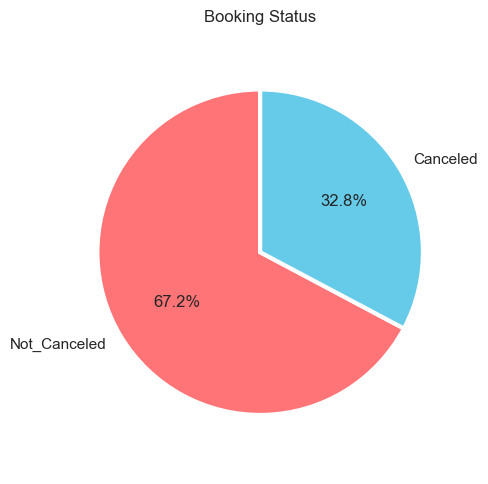

In [18]:
# Create data
booking_counts = df['booking_status'].value_counts()
labels = booking_counts.index
sizes = booking_counts.values

# --------------------------------------------------
# Pie Plot
fig, ax = plt.subplots(figsize = (5,5))

pcts = ax.pie(sizes,
              labels = labels,
              autopct = '%1.1f%%',
              colors = ['#ff7477', '#65cbe9'],
              wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},    # <------------- Style the wedges
              startangle = 90)

# Add a title
plt.title('Booking Status')

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')

plt.tight_layout()        # <------------- Adjust subplot spacing

# Display the chart
plt.show()

In [19]:
# Encode the target

# Instantiate the LabelEncoder
encoder = LabelEncoder()

# Encode the target variable in train dataset
Y_train_encoded = encoder.fit_transform(Y_train)

# Encode the target variable in test dataset
Y_test_encoded = encoder.transform(Y_test)

In [20]:
# Show encoding map for Y_train and Y_test
mappings = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))

mappings

{'Canceled': 0, 'Not_Canceled': 1}

The Target is slightly unbalanced. Thus, I will attempt to resample the training data.

<div style="background-color:  #ddedea; padding: 10px;">
    
### 6. Baseline models
    
</div>

In [21]:
# Models Pkgs
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Metrics Pkgs
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Pipeline Pkg
from imblearn.pipeline import Pipeline

In [22]:
# Put models in a dictionary

models = {'KNN': KNeighborsClassifier(),
          'LogReg': LogisticRegression(),
          'SVM': SVC(kernel = 'rbf',
                     random_state = 42),
          'XGBClass': XGBClassifier(),
          'RandomForest': RandomForestClassifier(random_state = 42)}

In [23]:
# Create a function to fit and score models

def baseline_models(models, X_train, X_test, Y_train_encoded, Y_test_encoded):
    """
    Fits and evaluates given machine learning models.
    models : a dict of differetn Scikit-Learn machine learning models
    X_train : training data (no labels)
    X_test : testing data (no labels)
    y_train : training labels
    y_test : test labels
    """
    
    # Set random seed
    np.random.seed(42)
    
    # Instantiate the resampling technique
    sampler = SMOTE(random_state = 42)       # <------ Apply SMOTE sampler as resampling technique
    
    # Make a dictionary to keep model scores
    model_scores = {}
    
    # Loop through models
    for name, model in models.items():
        
        # Create the pipeline
        pipe = Pipeline([('sampler', sampler),
                         (name, model)])
    
        # Fit the model to the data
        pipe.fit(X_train, Y_train_encoded)
        
        # Evaluate the model and append its score to model_scores
        model_scores[name] = [pipe.score(X_train, Y_train_encoded), pipe.score(X_test, Y_test_encoded)]
        
        print('\n ---------------------------------------------------------------------')
        print("Training accuracy for {}: {}".format(name, np.mean(pipe.predict(X_train) == Y_train_encoded)*100))
        print ('Test accuracy for {}: {}'.format(name, np.mean(pipe.predict(X_test) == Y_test_encoded)*100))
        
    return model_scores


 ---------------------------------------------------------------------
Training accuracy for KNN: 88.60096485182632
Test accuracy for KNN: 82.08132322536183

 ---------------------------------------------------------------------
Training accuracy for LogReg: 77.5223983459683
Test accuracy for LogReg: 77.94624396967609

 ---------------------------------------------------------------------
Training accuracy for SVM: 78.05995864920745
Test accuracy for SVM: 78.18056512749828

 ---------------------------------------------------------------------
Training accuracy for XGBClass: 90.73397656788423
Test accuracy for XGBClass: 88.10475534114404

 ---------------------------------------------------------------------
Training accuracy for RandomForest: 99.44521019986216
Test accuracy for RandomForest: 89.52446588559614


,KNN,LogReg,SVM,XGBClass,RandomForest
X_train,0.886010,0.775224,0.780600,0.907340,0.994452
X_test,0.820813,0.779462,0.781806,0.881048,0.895245


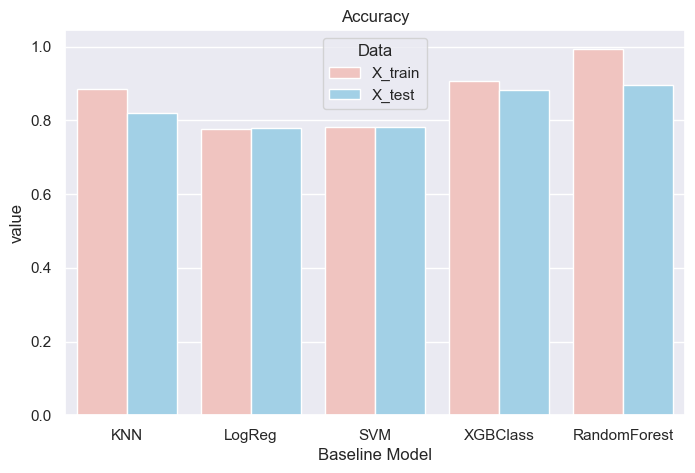

In [26]:
# instantiate the function

model_scores = baseline_models(models, X_train, X_test, Y_train_encoded, Y_test_encoded)

# model_scores

# --------------------------------------------------------------------------
# Model Comparison

model_compare = pd.DataFrame(model_scores, index=["X_train", 'X_test'])

display(model_compare)

model_compares = pd.melt(model_compare)
model_compares['Data'] = ['X_train', 'X_test', 'X_train', 'X_test', 'X_train', 'X_test', 'X_train', 'X_test', 'X_train', 'X_test']

# Set the color map for plots
colors = ['#f8bdb8', '#96d4f2']

plt.figure(figsize=(8, 5))

sns.barplot(data = model_compares,
            x = 'variable',
            y = 'value',
            hue = 'Data',
            palette = colors)

# Set labels and title
plt.xlabel('Baseline Model')
plt.title('Accuracy');

<div style="background-color:  #ddedea; padding: 10px;">
    
### 7. Data Reduction
    
</div>

**Filter methods**

It is a category of feature selection techniques used in data reduction. These methods assess the relevance of features based on their intrinsic properties, such as statistical measures or correlation with the target variable, without involving a specific machine learning algorithm. Filter methods are generally computationally efficient since they analyze features independently of the learning algorithm. They can quickly identify relevant features and reduce the dimensionality of the dataset. However, they may overlook interactions between features and the specific learning algorithm's requirements, potentially leading to suboptimal feature subsets.

**Embedded methods**

It is a category of feature selection techniques used in data reduction that perform feature selection as an inherent part of the learning algorithm itself. These methods aim to find the most relevant features while simultaneously optimizing the model's performance. Embedded methods are advantageous as they combine feature selection and model training, leading to more efficient and optimized feature subsets. However, they are typically specific to certain learning algorithms, and their performance heavily relies on the algorithm's capabilities and assumptions.

**Wrapper methods**

It is a category of feature selection techniques used in data reduction that evaluate feature subsets by training and testing a specific machine learning model. Wrapper methods tend to be computationally expensive since they involve training and evaluating the model multiple times. However, they can provide more accurate feature subsets tailored to the specific machine learning algorithm being used.

<div style="background-color:  #c6e2e9; padding: 10px;">  
    
**Filter methods**
    
Some commonly used filter methods are:

- Correlation wit target
- Pairwise correlation
- Chi-square Test
- Information Gain
- Mutual Information
- Variance Thresholding
- Univariate Selection
    
</div>  

**Correlation to target**

It corresponds to a **Filter Method** for Feature Selection

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,lead_time,arrival_year,arrival_month,arrival_date,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,type_of_meal_plan,required_car_parking_space,room_type_reserved,market_segment_type,repeated_guest,booking_status
25629,0.50,0.1,0.333333,0.058824,0.058691,0.0,0.818182,0.533333,0.0,0.016949,0.428762,0.0,0.0,0.0,1.0,0.0,0.0,0.0
14473,0.50,0.1,0.166667,0.058824,0.221219,1.0,0.545455,0.500000,0.0,0.016949,0.323569,0.4,0.0,0.0,1.0,0.0,0.0,1.0
23720,0.50,0.0,0.000000,0.176471,0.977427,1.0,0.727273,0.233333,0.0,0.016949,0.186418,0.0,0.0,0.0,1.0,1.0,0.0,1.0
5843,0.50,0.0,0.333333,0.294118,0.440181,1.0,0.636364,0.233333,0.0,0.016949,0.192410,0.0,0.0,0.0,1.0,1.0,0.0,1.0
18709,0.25,0.0,0.000000,0.117647,0.424379,1.0,0.454545,0.466667,0.0,0.016949,0.346205,0.0,0.0,0.0,1.0,1.0,0.0,1.0


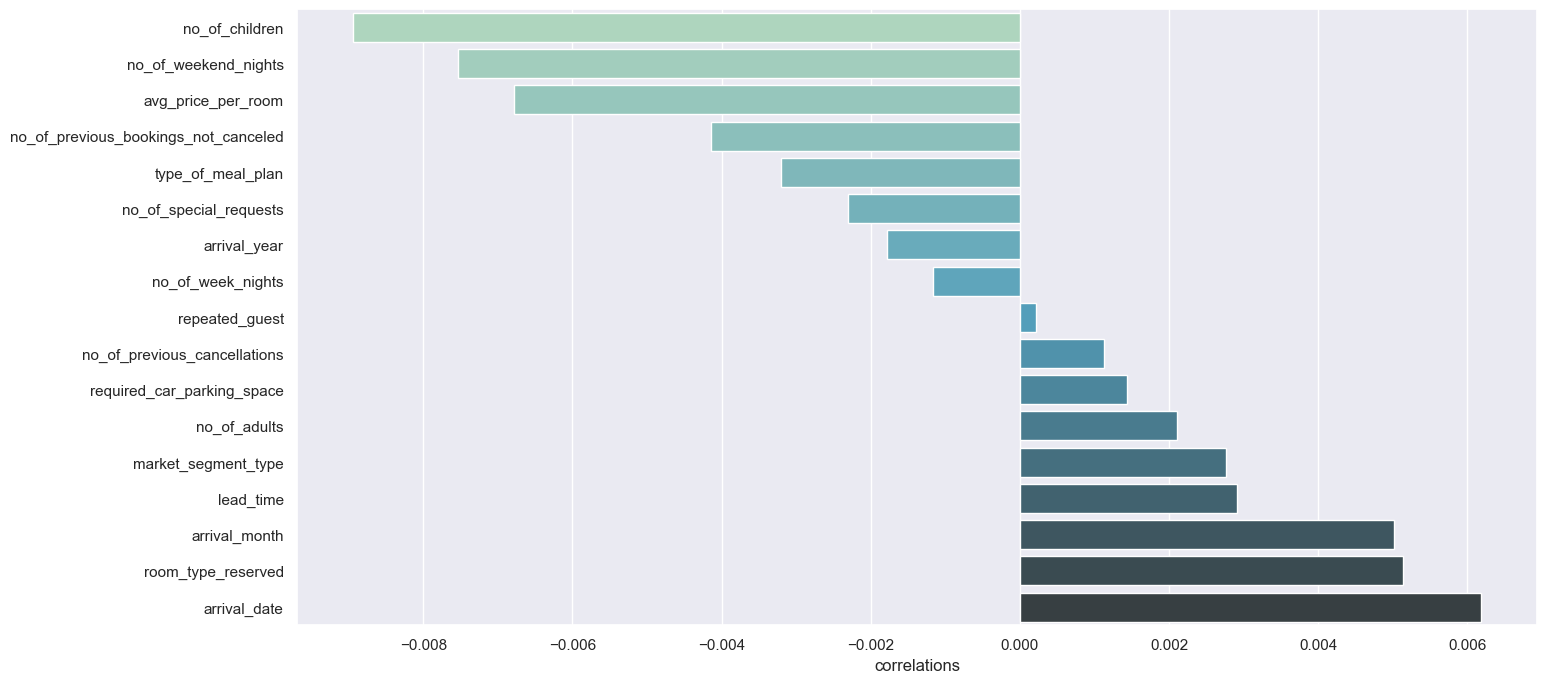

In [33]:
# Concatenating X_train and Y_train after encoding
Y_train_encoded = pd.Series(Y_train_encoded)
X_trainY_train = pd.concat([X_train,Y_train_encoded], axis = 1)
X_trainY_train = X_trainY_train.rename(columns = {0: 'booking_status'})
display(X_trainY_train.head())


# Compute correlation between all variables and 'booking_status'
df_corr = pd.DataFrame(X_trainY_train.corrwith(X_trainY_train['booking_status']).sort_values()[:-1],
                       columns = ['correlations'])
df_corr

plt.figure(figsize = (16,8))

# Plot the correlations to 'booking_status'
sns.barplot(x = df_corr['correlations'], 
            y = df_corr.index, 
            orient = 'h',
            palette = 'GnBu_d')

plt.show()

**Univariate Selection**

SelectKBest:

It is a univariate feature selection method. The higher the score, the more relevant the feature is considered to be for predicting the target variable.

For classification problems with discrete targets, common scoring functions include chi2, f_classif, mutual_info_classif, etc. **I will use f_classif**.

,Scores
lead_time,6667.66
no_of_special_requests,1974.64
arrival_year,888.97
avg_price_per_room,608.72
repeated_guest,333.88
market_segment_type,307.86
no_of_week_nights,260.85
no_of_adults,248.51
required_car_parking_space,221.56
type_of_meal_plan,116.58


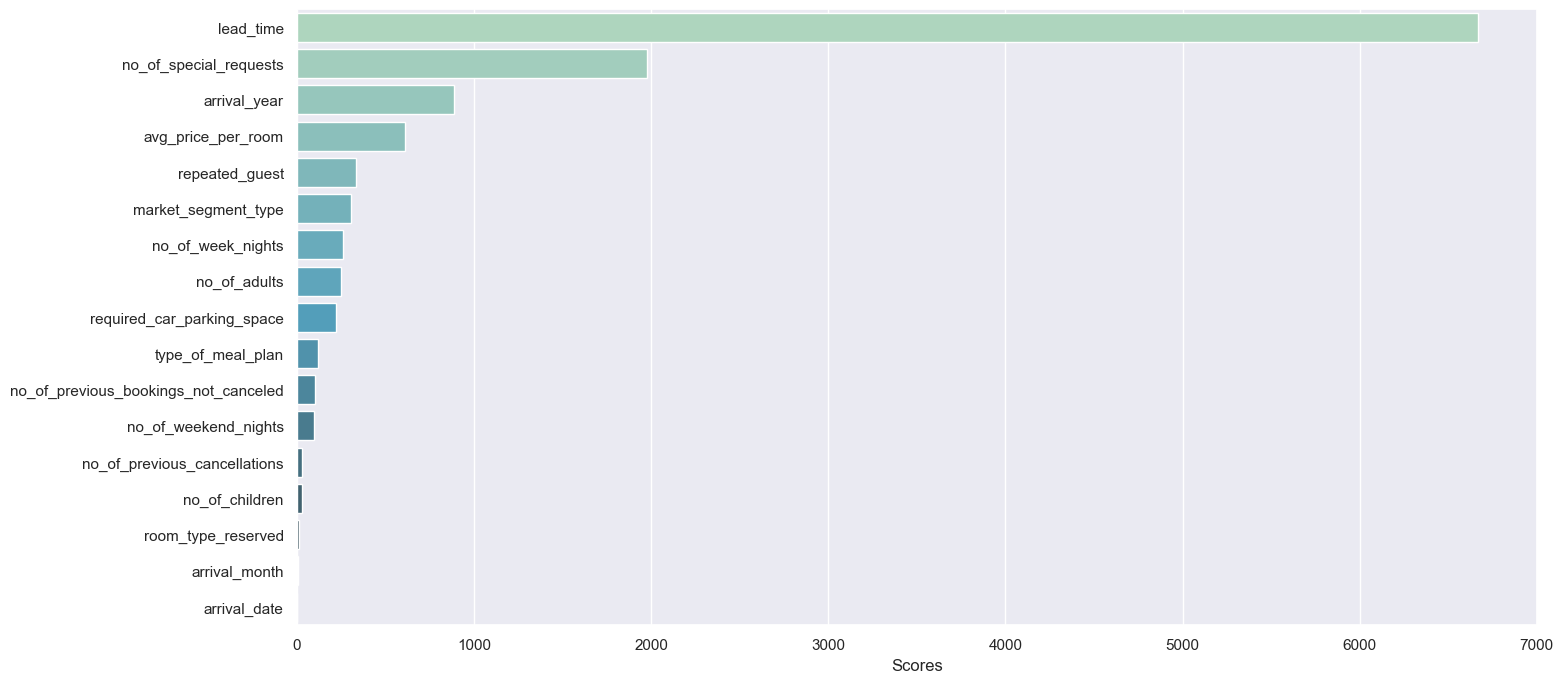

In [34]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# Apply SelectKBest to get the k most important features
selector = SelectKBest(score_func = f_classif,               # <------- ANOVA
                       k = 'all')                            # <------- number of features to select

X_new = selector.fit_transform(X_train, Y_train_encoded)

# get selected feature scores
scores = selector.scores_

# create dataframe with the scores for each feature
df_featscores = pd.DataFrame(scores, 
                             index = list(X_train.columns),
                             columns = ['Scores'])

# sort scores in descending order
df_featscores = df_featscores.sort_values(by = 'Scores', 
                                          ascending = False).round(2)

display(df_featscores)

# -----------------------------------------------------------
# Plot features scores

plt.figure(figsize = (16,8))

sns.barplot(x = df_featscores['Scores'], 
            y = df_featscores.index, 
            orient = 'h',
            palette = 'GnBu_d')

plt.show()


<div style="background-color:  #c6e2e9; padding: 10px;"> 

**Embedded methods**
    
Some commonly used filter methods are:
    
- L1 LASSO (Least Absolute Shrinkage and Selection Operator) regularization
- Ridge Regression
- Elastic Net
- Decision Tree-based Methods (Random Forest, Gradient Boosting)  
</div>

**Decision Tree-based method**

Random Forest:

The ensemble ML algorithm Random Forest provides a good indicator of the feature importance. This correspond to **Embedded Method** for Feature Selection.

,Importance
lead_time,0.296882
avg_price_per_room,0.146746
no_of_special_requests,0.116780
arrival_month,0.094774
arrival_date,0.090648
no_of_week_nights,0.067739
market_segment_type,0.048857
no_of_weekend_nights,0.040148
arrival_year,0.027496
no_of_adults,0.023714


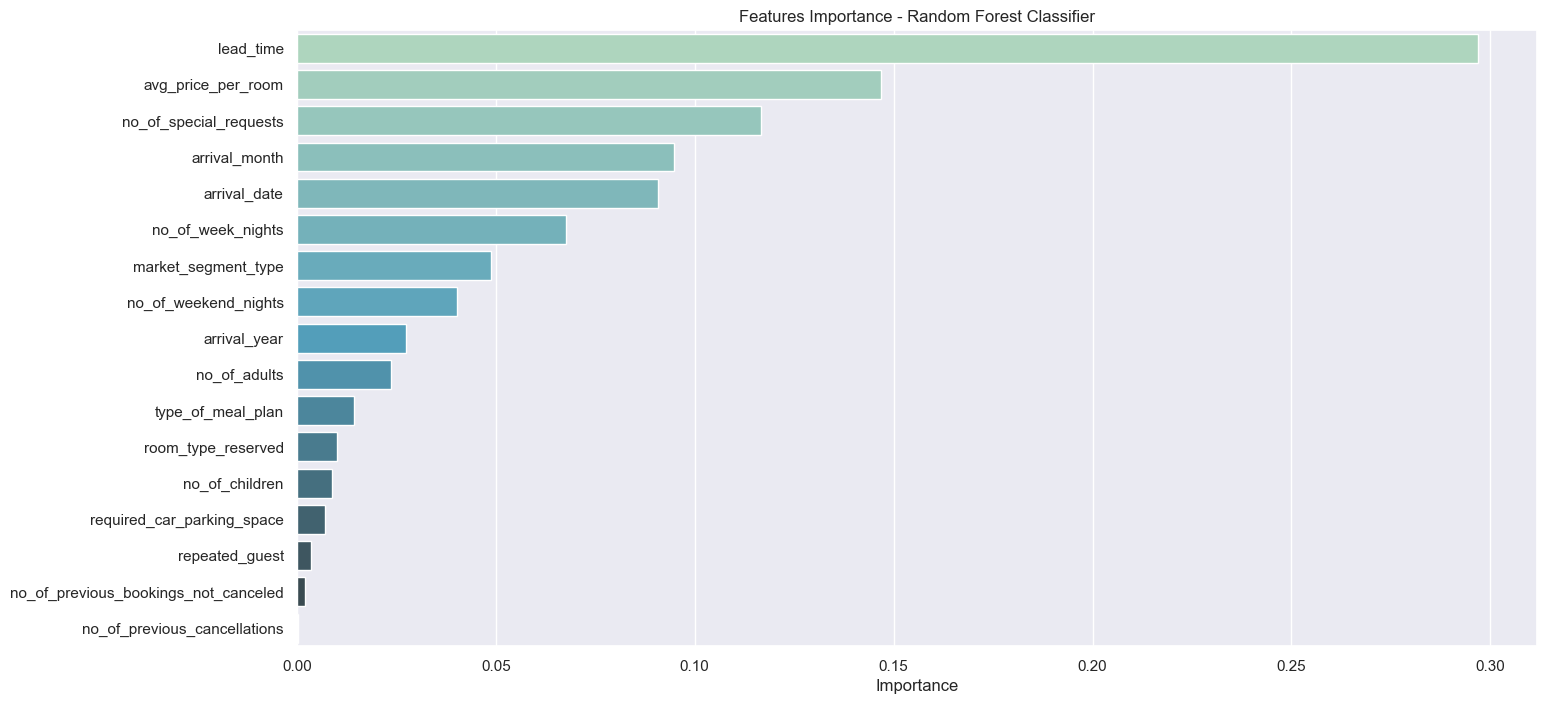

In [35]:
# Instantiate the resampling technique
sampler = SMOTE(random_state = 42)       # <------ Apply SMOTE sampler as resampling technique

# Create the pipeline
pipe = Pipeline([('sampler', sampler),
                 ('RandomForest', RandomForestClassifier(random_state = 42))])

# Fit the model to the train data
pipe.fit(X_train, Y_train_encoded)

# Get the feature importance according to Random Forest
df_rfimportance = pd.DataFrame(pipe.named_steps['RandomForest'].feature_importances_,
                               index = list(X_train.columns),
                               columns = ['Importance'])

# Sort the features according to their importance in descending order
df_rfimportance_sorted = df_rfimportance.sort_values(by = 'Importance',
                                                     ascending = False)

display(df_rfimportance_sorted)

# -----------------------------------------------------------
# Plot features scores

plt.figure(figsize = (16,8))

sns.barplot(x = df_rfimportance_sorted['Importance'], 
            y = df_rfimportance_sorted.index, 
            orient = 'h',
            palette = 'GnBu_d')

plt.title("Features Importance - Random Forest Classifier")
plt.show()

XGBoost:

The gradient boosting algorithm XGBoost provides embedded feature importance calculation. The feature importance calculation in XGBoost is typically derived from the number of times a feature is used to split the data across all decision trees in the ensemble. These importance scores can help identify which features have the most impact on the model's predictions.

According to https://mljar.com/blog/feature-importance-xgboost/ there are 3 different ways to get feature importance from XGBoost:

 - use buil-in feature importance **(I will use this)**
 - use permutation based importance (explained below)
 - use shap based importance (see in link)
 
 Important!
 
 There are several types of importance in the Xgboost - it can be computed in several different ways:
 - The `gain` type shows the average gain across all splits where feature was used. This is the default type  if you construct model with scikit-learn like API.
 - The `weight` shows the number of times the feature is used to split data. This type of feature importance can favourize numerical and high cardinality features. Be careful! This is the default type when you access `Booster` object and get the importance with `get_score` method.
 - There are also `cover`, `total_gain`, `total_cover` types of importance.
 
 You can check the type of the importance with `xgb.importance_type`. 

,Importance
market_segment_type,0.221779
no_of_special_requests,0.125454
required_car_parking_space,0.106107
lead_time,0.095165
arrival_year,0.071537
no_of_week_nights,0.057329
no_of_adults,0.052927
arrival_month,0.048855
no_of_weekend_nights,0.040542
repeated_guest,0.034722


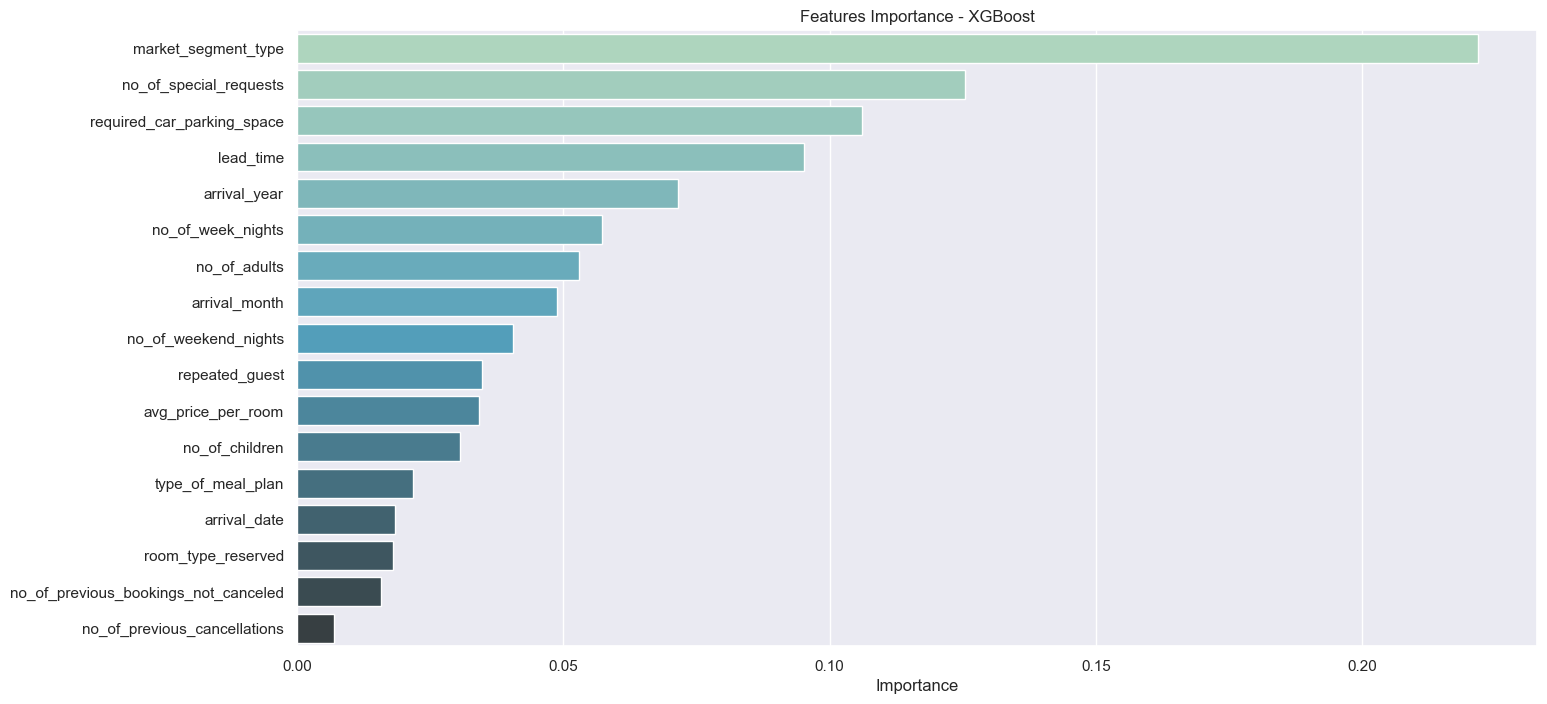

In [86]:
# Create the pipeline
pipe_xgb = Pipeline([('sampler', sampler),
                     ('XGB', XGBClassifier(n_estimators = 100))])

# Fit the model to the train data
pipe_xgb.fit(X_train, Y_train_encoded)

# Get the indices of the features sorted by the importance values
indices = pipe_xgb.named_steps['XGB'].feature_importances_.argsort()

# Get the random forest feature importance via permutation importance
df_xgbimpor = pd.DataFrame(pipe_xgb.named_steps['XGB'].feature_importances_,
                           index = list(X_train.columns),
                           columns = ['Importance'])

# Sort the features according to their importance in descending order
df_xgbimpor_sorted = df_xgbimpor.sort_values(by = 'Importance',
                                             ascending = False)

display(df_xgbimpor_sorted)

# -----------------------------------------------------------
# Plot features scores

plt.figure(figsize = (16,8))

sns.barplot(x = df_xgbimpor_sorted['Importance'], 
            y = df_xgbimpor_sorted.index, 
            orient = 'h',
            palette = 'GnBu_d')

plt.title("Features Importance - XGBoost")
plt.show()

<div style="background-color:  #c6e2e9; padding: 10px;"> 

**Wrapper methods**
    
Some commonly used filter methods are:
    
- Recursive Feature Elimination (RFE)
- Sequential Feature Selection (SFS)
    - Sequential Forward Selection
    - Sequential Backward Selection
- Permutation Importance
- Genetic Algorithms  
</div>

**Recursive Feature Elimination (RFE)**

**Pros**
- [x] Can explicity select number of features
- [x] Not super expensive (if linear model is used)
- [x] Takes features interaction into account

---
**Cons**
- [ ] Assumes linear separability (if linear model is used)
- [ ] Does not optimize performance metric directly
- [ ] Needs search method to find good number of features

In [30]:
# Basic implementation of RFE

from sklearn.feature_selection import RFE

lr = LogisticRegression(solver = 'liblinear',
                        random_state = 123)

# Instantiate the RFE
rfe = RFE(estimator = lr,
          n_features_to_select = 15,            # <-------- it is arbitrary. To select the best I need to do GridSearch + CrossValidation
          step = 1)                             # <-------- number of features that are eliminated at each iteration

# fit the model
rfe.fit(X_train, Y_train_encoded)

# transform the training data
X_train_sub = rfe.transform(X_train)

# Show which features are selected
X_train.columns[rfe.support_]

Index(['no_of_adults', 'no_of_children', 'no_of_weekend_nights', 'no_of_week_nights', 'lead_time', 'arrival_year', 'arrival_month', 'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled', 'avg_price_per_room', 'no_of_special_requests', 'required_car_parking_space', 'room_type_reserved', 'market_segment_type', 'repeated_guest'], dtype='object')

**RFE as part of a Pipeline**

To select the number of features selected (features subset size) at witch a given model get the best accuracy.

So far I experimented with:
- KNN

In [31]:
from sklearn.model_selection import GridSearchCV

# Create the pipeline
pipe = Pipeline([('sampler', sampler),
                 ('RFE', RFE(estimator = lr, step = 1)),
                 ('model', KNeighborsClassifier())])

# Define the search space
search_space = {'RFE__n_features_to_select': range(1, 17),     # <----- number of features to select
                'model__n_neighbors': range(1, 10)}            # <----- number of neighbors to consider in KNN

# Instantiate the grid search for RFE with KNN
grid = GridSearchCV(pipe,
                    param_grid = search_space,
                    cv = 5,
                    n_jobs = 1)

# Fit the grid search with the train data
grid.fit(X_train, Y_train_encoded)

print('Best params:', grid.best_params_)
print('Best accuracy:', grid.best_score_)

Best params: {'RFE__n_features_to_select': 12, 'model__n_neighbors': 1}
Best accuracy: 0.8379048931771192


In [33]:
# Reduced feature set from grid search

grid.best_estimator_.score(X_test, Y_test_encoded)

0.8501722949689869

In [34]:
# For reference full feature set

# Create the pipeline with KNN  with the optimal number of neighbors
pipe_knn = Pipeline([('sampler', sampler),
                     ('KNN', KNeighborsClassifier(n_neighbors = 1))])

# Fit the model with the train data
pipe_knn.fit(X_train, Y_train_encoded)

# Accuracy Score with the test data 
pipe_knn.score(X_test, Y_test_encoded)

# ---------------------------------------------------------
print('\n ---------------------------------------------------------------------')
print("Training accuracy for {}: {}".format('KNN', np.mean(pipe_knn.predict(X_train) == Y_train_encoded)*100))
print ('Test accuracy for {}: {}'.format('KNN', np.mean(pipe_knn.predict(X_test) == Y_test_encoded)*100))


 ---------------------------------------------------------------------
Training accuracy for KNN: 99.10751206064784
Test accuracy for KNN: 83.3631977946244


**Explore Base Algorithm with RFE**

I explore whitch algorithm used in the core of RFE (wrapped by RFE), provide the best accuracy for a given model.

So far I experimented with:

- DecisionTreeClassifier

In [35]:
# Put models for RFE in a dictionary

models = {'LogReg': LogisticRegression(),
          'DecTree': DecisionTreeClassifier(), 
          'RandomForest': RandomForestClassifier(random_state = 42),
          'GradientBoost': GradientBoostingClassifier()}

def get_pipes(models):
    '''
    Creates the pipelines with RFE and models
    '''
    
    pipes = dict()
    
    for name, model in models.items():
        
        # Instantiate the resampling technique
        sampler = SMOTE(random_state = 42)       # <------ Apply SMOTE sampler as resampling technique
        
#         Instantiate the RFE
        rfe = RFE(estimator = model, n_features_to_select = 15)     # <---- I fix 12 the number of features to select (arbitrary)
        
#         Add the pipeline to dict "pipes"
        pipes[name] =Pipeline([('s', rfe),
                               ('sampler', sampler),
                               ('model', DecisionTreeClassifier())])
    
    return pipes

In [36]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

def rfe_func(X_train, Y_train, pipes):
    """
    Fits and evaluates RFE with given machine learning models using cross-validation
    pipes : a dict of different pipelines with the models in "models" including RFE
    X_train : training data 
    Y_train : training labels
    """
    
#     Make a dictionary to keep model scores
    models_scores = {}
    
#     Instantiate the number of folds
    cv = RepeatedStratifiedKFold(n_splits = 10,
                                 n_repeats = 3,
                                 random_state = 1)
    
#     Evaluate the cross-validation with X_train and Y_train for each pipeline in "pipes"
    for name, pipe in pipes.items():
        scores = cross_val_score(pipe,                      # <------ estimator (unfitted!)
                                 X_train,
                                 Y_train,
                                 cv = cv,                   # <------ number of folds for cross-validation
                                 scoring = 'accuracy',      # <------ scoring function (model quality metric) 
                                 n_jobs = 1)                # <------ parallel running, for memory efficiency
        
#         Add the scores in "models_scores"
        models_scores[name] = scores
    
    return models_scores

In [37]:
# Action and show results:

# Create the pipelines
pipes = get_pipes(models)

# Apply rfe
scores = rfe_func(X_train, Y_train_encoded, pipes)


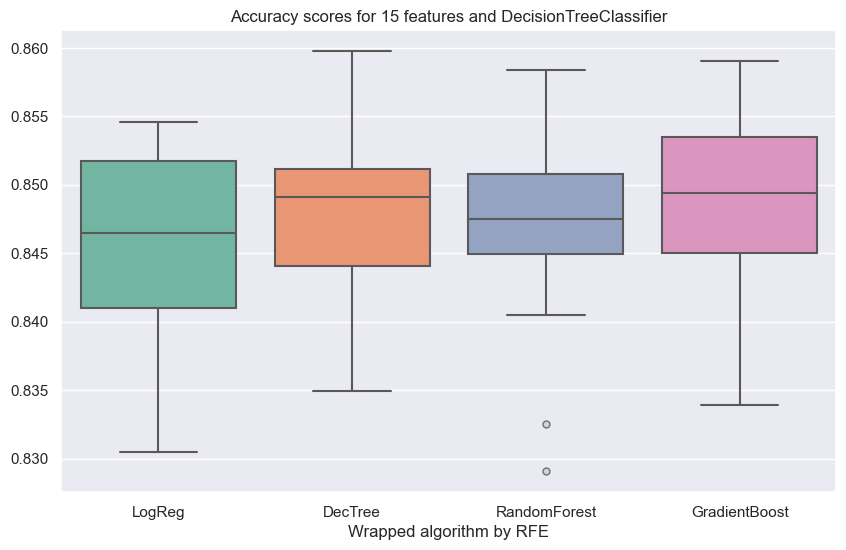

Mean accuracy scores for each wrapped algorithm by RFE for DecisionTreeClassifier() model:
-----------------------------------------------------------------------------------------


,mean_accuracy,std
LogReg,0.845474,0.006612
DecTree,0.848036,0.005653
RandomForest,0.847186,0.006451
GradientBoost,0.848266,0.006656


In [38]:
# Convert "scores" in a dataframe
scores = pd.DataFrame(scores)

# ---------------------------------------
# Boxplot with the scores for 12 features selected by RFE for each model

# Styling the Outliers of the boxplots
flierprops = dict(marker='o', markersize=5, markeredgecolor='black', markerfacecolor='#b8c0c8', alpha=0.5)

plt.figure(figsize = (10,6))

sns.boxplot(data = scores,
            palette = 'Set2',
            flierprops = flierprops)

plt.xlabel('Wrapped algorithm by RFE')
plt.title('Accuracy scores for 15 features and DecisionTreeClassifier')

plt.show()

# -------------------------------------------
# Mean scores with their standard deviations
mean_values = scores.mean()
std_values = scores.std()

means_stds = pd.concat([mean_values, std_values], axis = 1)
means_stds.columns = ['mean_accuracy', 'std']

print('Mean accuracy scores for each wrapped algorithm by RFE for DecisionTreeClassifier() model:')
print('-----------------------------------------------------------------------------------------')
display(means_stds)

**Sequential Feature Selection (SFS)**

So far I experimented with:

- **KNN**
  - ['no_of_weekend_nights', 'lead_time', 'arrival_year', 'arrival_month', 'no_of_previous_cancellations', 'avg_price_per_room', 'no_of_special_requests', 'type_of_meal_plan', 'required_car_parking_space', 'market_segment_type']
  
- **XGBoost**
    - ['no_of_adults', 'no_of_children', 'no_of_weekend_nights', 'no_of_week_nights', 'lead_time', 'arrival_year', 'arrival_month', 'arrival_date', 'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled', 'avg_price_per_room', 'no_of_special_requests', 'type_of_meal_plan', 'required_car_parking_space', 'room_type_reserved', 'market_segment_type']

- Selecting the best 15 features (15 is an arbitrary choice)

In [90]:
# Instantiate the model and fit it to the train data

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

sfs1 = SFS(pipe_xgb,
           k_features = 15,                     # <------- Number of features to select by SFS
           forward = True,                      # <------- Forward selection
           floating = False,                    # <------- No floating
           verbose = 2,                         # <------- Show output during training (useful for large data)
           scoring = 'accuracy',
           n_jobs = -1,                         # <------- To fit things in parallel (useful to improve runtime performance)
           cv = 5)

sfs1 = sfs1.fit(X_train, Y_train_encoded)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  17 | elapsed:   31.4s remaining:  1.3min
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:   32.1s remaining:    6.8s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:   32.5s finished

[2023-07-05 09:28:13] Features: 1/15 -- score: 0.7356650585802894[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  16 | elapsed:    3.2s remaining:    9.9s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    4.1s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    4.2s finished

[2023-07-05 09:28:17] Features: 2/15 -- score: 0.7796691936595452[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    5.0s remaining:    4.4s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    5.3s finished

[2023-07-05 09:28:

In [91]:
# See the index of each selected feature

print(sfs1.k_feature_idx_)

# See the features names if I fit the model with pandas DataFrame
print(df_clean.columns[list(sfs1.k_feature_idx_)])

(0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15)
Index(['no_of_adults', 'no_of_children', 'no_of_weekend_nights', 'no_of_week_nights', 'lead_time', 'arrival_year', 'arrival_month', 'arrival_date', 'no_of_previous_bookings_not_canceled', 'avg_price_per_room', 'no_of_special_requests', 'type_of_meal_plan', 'required_car_parking_space', 'room_type_reserved', 'market_segment_type'], dtype='object')


In [93]:
# Accuracy for the model using features selected by sfs1

X_train_select = sfs1.transform(X_train)
X_test_select = sfs1.transform(X_test)

pipe_xgb.fit(X_train_select, Y_train_encoded)

print('\n ---------------------------------------------------------------------')
print("Training accuracy for {}: {}".format('XGBoost', np.mean(pipe_xgb.predict(X_train_select) == Y_train_encoded)*100))
print ('Test accuracy for {}: {}'.format('XGBoost', np.mean(pipe_xgb.predict(X_test_select) == Y_test_encoded)*100))


 ---------------------------------------------------------------------
Training accuracy for XGBoost: 90.54100620261887
Test accuracy for XGBoost: 88.06340454858717


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(4,)","[0.7338042729152309, 0.7419021364576155, 0.721...",0.735665,"(lead_time,)",0.00999,0.007772,0.003886
2,"(4, 10)","[0.7767057201929704, 0.7827360441075121, 0.778...",0.779669,"(lead_time, avg_price_per_room)",0.005328,0.004146,0.002073
3,"(4, 10, 11)","[0.841144038594073, 0.8351137146795313, 0.8358...",0.836595,"(lead_time, avg_price_per_room, no_of_special_...",0.005242,0.004078,0.002039
4,"(4, 10, 11, 15)","[0.8564782908339077, 0.8549276361130255, 0.845...",0.850241,"(lead_time, avg_price_per_room, no_of_special_...",0.006919,0.005383,0.002692
5,"(4, 6, 10, 11, 15)","[0.8659545141281875, 0.8631977946243969, 0.860...",0.860096,"(lead_time, arrival_month, avg_price_per_room,...",0.007391,0.005751,0.002875
6,"(4, 6, 7, 10, 11, 15)","[0.8654376292212267, 0.8683666436940042, 0.864...",0.863921,"(lead_time, arrival_month, arrival_date, avg_p...",0.00474,0.003688,0.001844
7,"(2, 4, 6, 7, 10, 11, 15)","[0.8752584424534804, 0.874052377670572, 0.8709...",0.870572,"(no_of_weekend_nights, lead_time, arrival_mont...",0.004933,0.003838,0.001919
8,"(2, 3, 4, 6, 7, 10, 11, 15)","[0.8774982770503101, 0.8816333563059958, 0.870...",0.873708,"(no_of_weekend_nights, no_of_week_nights, lead...",0.00764,0.005945,0.002972
9,"(2, 3, 4, 5, 6, 7, 10, 11, 15)","[0.877842866988284, 0.883184011026878, 0.87491...",0.875913,"(no_of_weekend_nights, no_of_week_nights, lead...",0.006163,0.004795,0.002398
10,"(2, 3, 4, 5, 6, 7, 10, 11, 13, 15)","[0.8840454858718125, 0.8842177808407995, 0.875...",0.876465,"(no_of_weekend_nights, no_of_week_nights, lead...",0.008852,0.006887,0.003444


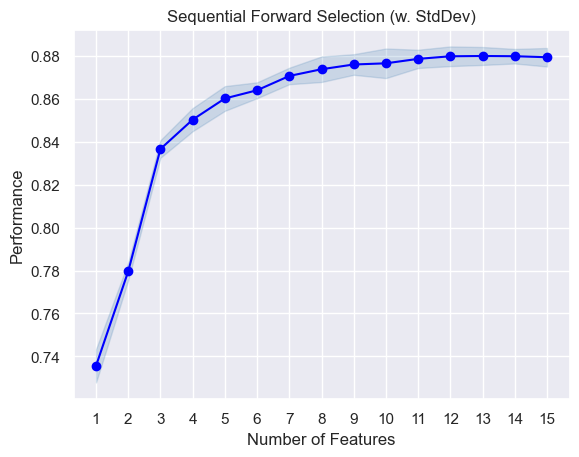

In [94]:
# Detail information I can look at after fitting the Sequential Feature Selector

# 1- Detail information about each subset of features that is analized by the SFS
sfs1.subsets_

# 2- Add the confidence interval bounds on the standard deviation
metric_dict = sfs1.get_metric_dict(confidence_interval = 0.95)
metric_dict

# 3. Detail information in DataFrame format
df_sfs = pd.DataFrame.from_dict(metric_dict).T
display(df_sfs)

# 4. Plot with the accuracy for each set of features
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

fig1 = plot_sfs(metric_dict, 
                kind = 'std_dev')
plt.title('Sequential Forward Selection (w. StdDev)')
plt.show()

- To select the number of features selected (features subset size) at witch a given model get the best accuracy. 

In [95]:
# Instantiate the model and fit it to the train data

sfs1 = SFS(pipe_xgb,
           k_features = 'best',          # <--------- or (1, 13) and then select by hand
           forward = True,                      
           floating = False,                    
           verbose = 0,                  # <--------- it is 0 so there is no printing of the results during the run        
           scoring = 'accuracy',
           n_jobs = -1,                        
           cv = 5)

sfs1 = sfs1.fit(X_train, Y_train_encoded)

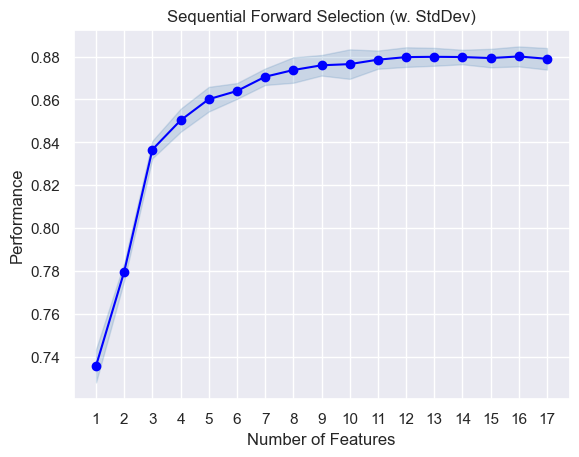

Indices of the features selected by sfs1: (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15)
Index(['no_of_adults', 'no_of_children', 'no_of_weekend_nights', 'no_of_week_nights', 'lead_time', 'arrival_year', 'arrival_month', 'arrival_date', 'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled', 'avg_price_per_room', 'no_of_special_requests', 'type_of_meal_plan', 'required_car_parking_space', 'room_type_reserved', 'market_segment_type'], dtype='object')

 ---------------------------------------------------------------------
Training accuracy for XGBoost: 90.3893866299104
Test accuracy for XGBoost: 87.9393521709166


In [96]:
# Plot 
metric_dict = sfs1.get_metric_dict(confidence_interval = 0.95)

fig1 = plot_sfs(metric_dict, kind = 'std_dev')

plt.title('Sequential Forward Selection (w. StdDev)')
plt.show()

# Indices of the features selected by sfs1
print('Indices of the features selected by sfs1:', sfs1.k_feature_idx_)

# See the features names if I fit the model with pandas DataFrame
print(df_clean.columns[list(sfs1.k_feature_idx_)])

# ------------------------------------------------------------------------
# Accuracy for the model using features selected by sfs1
X_train_select = sfs1.transform(X_train)
X_test_select = sfs1.transform(X_test)

pipe_xgb.fit(X_train_select, Y_train_encoded)

print('\n ---------------------------------------------------------------------')
print("Training accuracy for {}: {}".format('XGBoost', np.mean(pipe_xgb.predict(X_train_select) == Y_train_encoded)*100))
print ('Test accuracy for {}: {}'.format('XGBoost', np.mean(pipe_xgb.predict(X_test_select) == Y_test_encoded)*100))

**SIDE NOTE**

**Exhaustive Search**

Number of combinations of features subsets to check if is feasible (> 100000 combinations it might not be feasible!)

In [45]:
from mlxtend.math import num_combinations

all_combs = np.sum(num_combinations(n = X_train.shape[1], k=i) for i in range(1, X_train.shape[1]+1))

all_combs

131071

In [ ]:
# # Apply a exhaustive feature selector 
# from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS

# # Instantiate the model
# efs1 = EFS(knn,
#            min_features = 1,                           # <--------- i in the Total of combinations formula
#            max_features = X_train.shape[1],            # <--------- m in the Total of combinations formula
#            scoring = 'accuracy',
#            print_progress = True,
#            n_jobs = -1,
#            cv = 5)

# # Fit the model to the train data 
# efs1 = efs1.fit(X_train, Y_train_encoded)

In [ ]:
# # Show the best subset of features after the exhaustive search

# efs1.best_idx_

**Sequential Feature Selection in Scikit-learn**

- Simpler interface
- Use this if you are interested in a **specific feature size** and dont want to use **floating variants**.

In [46]:
from sklearn.feature_selection import SequentialFeatureSelector as SFS

sfs2 = SFS(pipe_knn,
           n_features_to_select = 10,            # <--------- 10 is the size of the feature subset with the best accuracy
           direction = 'forward',
           scoring = 'accuracy',
           n_jobs = -1,
           cv = 5)

sfs2 = sfs2.fit(X_train, Y_train_encoded)

In [47]:
# Show the indices of the selected features

np.arange(X_train.shape[1])[sfs2.support_]

array([ 2,  4,  5,  6,  8, 10, 11, 12, 13, 15])

**Feature Permutation Importance (FPI)**


**Pros**
- [x] Model agnostic (it can be used with any classifier: random forest, logreg, deep learning model, etc..)
- [x] Based on metric of choice (accuracy, f1_score, MCC, R^2)
- [x] Easy to understand
- [x] Unlike impurity-based random forest importance, it does not suffer from "overfitting" since an independent dataset is used

- [+/-] Feature importance is for that particular model (feature might be more/less important to another model)

---
**Cons**
- [ ] Like in impurity-based random forest importance. the importance is undervalued if two features are highly correlated

**OJO**: It is very important to have a very well performing model when using Feature Permutation Importance 

In [48]:
# For reference full feature set
# Apply pipeline with SMOTE and RandomForesClassifier 

# Instantiate pipe with Random Forest
pipe_rf = Pipeline([('sampler', sampler),
                    ('RandomForest', RandomForestClassifier(n_estimators = 100,     # <-------- Using 100 decision trees
                                                            random_state = 0))])

# Fit the model with the train data
pipe_rf.fit(X_train, Y_train_encoded)

# ---------------------------------------------------------
print('\n ---------------------------------------------------------------------')
print("Training accuracy for {}: {}".format('Random Forest', np.mean(pipe_rf.predict(X_train) == Y_train_encoded)*100))
print ('Test accuracy for {}: {}'.format('Random Forest', np.mean(pipe_rf.predict(X_test) == Y_test_encoded)*100))

# ----------------------------------------------------
# The impurity-based feature importance embbeded in Random Forest is already calculated and plotted in a previous cell


 ---------------------------------------------------------------------
Training accuracy for Random Forest: 99.43831840110269
Test accuracy for Random Forest: 89.35906271536871


In [54]:
# Apply Permutation Feature Importance
from mlxtend.evaluate import feature_importance_permutation

# Convert Y_test_encoded to a pandas DataFrame if it is not already
# Y_test_encoded = pd.Series(Y_test_encoded)

imp_vals, imp_all = feature_importance_permutation(   # <--- imp_vals: the importance values. imp_all: 
    predict_method = pipe_rf.predict,
    X = X_test.values,                                # <--- Or X_test.to_numpy() (It must be a numpy array)
    y = Y_test_encoded.values,                        # <--- Or Y_test_encoded.to_numpy() (It must be a numpy array)
    metric = 'accuracy',
    num_rounds = 20,                                  # <--- Number of times I repeat the permutation of the column
    seed = 0)

**Comparison, via plots, of the impurity-based Random Forest feature importance and Random Forest feature importance via Permutation importance:**

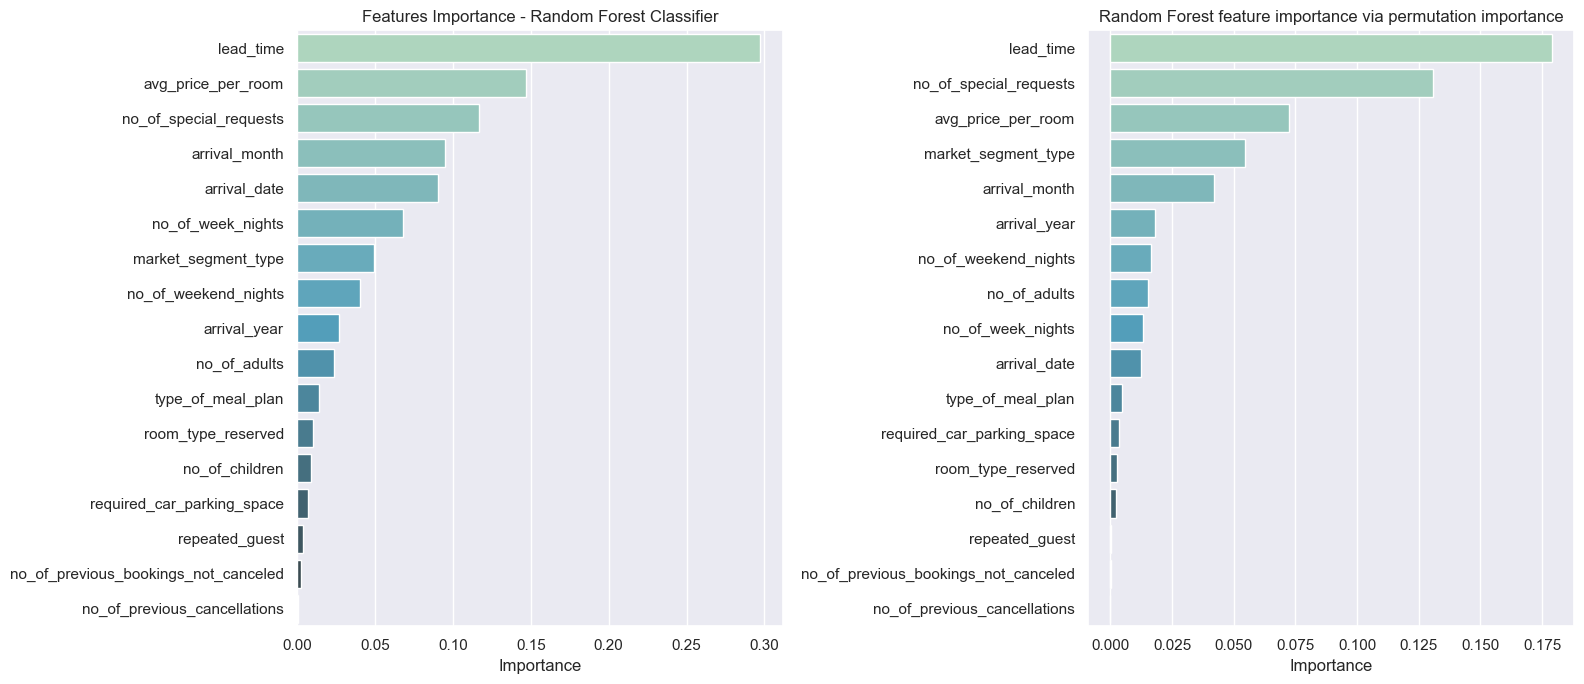

In [64]:
# --------------------------------------------------------------------
# Plot of feature importance embbeded in Random Forest

fig, ax = plt.subplots(ncols = 2,
                       figsize = (16,7))

sns.barplot(x = df_rfimportance_sorted['Importance'], 
            y = df_rfimportance_sorted.index, 
            orient = 'h',
            palette = 'GnBu_d',
            ax = ax[0])

ax[0].set_title("Features Importance - Random Forest Classifier")

# ---------------------------------------------------------------------
# Plot of Random Forest feature importance via permutation importance

std = np.std(imp_all, axis = 1)           # <---- for each feature, I compute the std for all its importance values
indices = np.argsort(imp_vals)[::-1]      # <---- the indices of the features for each imp_values sorted in descendent order

# Get the random forest feature importance via permutation importance
df_permimpor = pd.DataFrame(imp_vals[indices],
                            index = list(X_train.columns[indices]),
                            columns = ['Importance'])

sns.barplot(x = df_permimpor['Importance'],
            y = df_permimpor.index,
            orient = 'h',
            palette = 'GnBu_d',
            ax = ax[1])

ax[1].set_title('Random Forest feature importance via permutation importance')

plt.tight_layout()
plt.show()

I observ that, choosing the first 4 features in both plots, that both feature importances methods select the same features as the 4 most important

**Comparison of Permutation Importance in mlxtend vs Permutation Importance in scikit-learn**

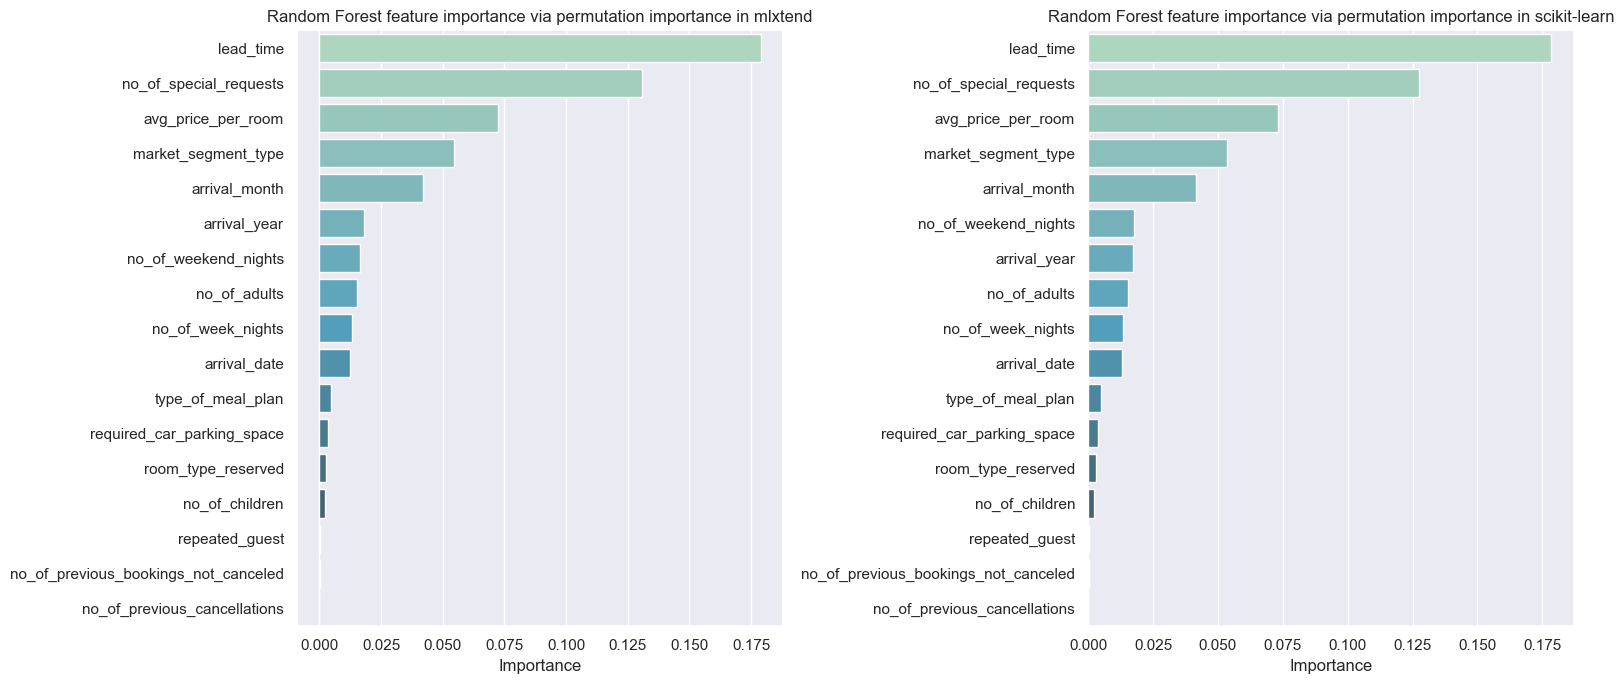

In [68]:
# Permutation Importance in scikit-learn

from sklearn.inspection import permutation_importance

# Apply Permutation Importance to the pipe_rf
result = permutation_importance(estimator = pipe_rf,
                                X = X_test,
                                y = Y_test_encoded,
                                scoring = 'accuracy',
                                n_repeats = 20,
                                random_state = 0)

# Extract the feature importances from the result
importances = result.importances_mean

# Create df with the permutation importances
df_permimporskl = pd.DataFrame(result.importances_mean,              # <---- extract the feature importances from 'result'
                               index = X_train.columns,
                               columns = ['Importance'] 
                              )

# Sort the features according to their importance in descending order
df_permimporskl_sorted = df_permimporskl.sort_values(by = 'Importance',
                                                     ascending = False)

# ------------------------------------------------------------------
# Plots

fig, ax = plt.subplots(ncols = 2,
                       figsize = (16,7))

sns.barplot(x = df_permimpor['Importance'],
            y = df_permimpor.index,
            orient = 'h',
            palette = 'GnBu_d',
            ax = ax[0])

ax[0].set_title('Random Forest feature importance via permutation importance in mlxtend')

sns.barplot(x = df_permimporskl_sorted['Importance'],
            y = df_permimporskl_sorted.index,
            orient = 'h',
            palette = 'GnBu_d',
            ax = ax[1])

ax[1].set_title('Random Forest feature importance via permutation importance in scikit-learn')

plt.tight_layout()
plt.show()

I confirm that the Permutation Importance works the same in mlxtend and in scikit-learn.

**SIDE NOTES**

**Random Feature as Control**

When I compute the Permutation Importance, it is useful to include a random feature in the dataset as a control that can give me an idea of what is a meaningful feature importance and what is not.

In [76]:
np.random.seed(123)

# Create a random column for training and test data
x1 = np.random.randn(X_train.shape[0]).reshape(-1,1)
x2 = np.random.randn(X_test.shape[0]).reshape(-1,1)

# Stack train and test data with extra columns
X_train_r = pd.DataFrame(np.hstack((X_train, x1)),
                         index = X_train.index,
                         columns = list(X_train.columns) + ['Random']
                        )
X_test_r = pd.DataFrame(np.hstack((X_test, x2)),
                        index = X_test.index,
                        columns = list(X_test.columns) + ['Random']
                       )

# Show training and test data with extra column
display(X_train_r.shape)
display(X_test_r.shape)

(29020, 18)

(7255, 18)

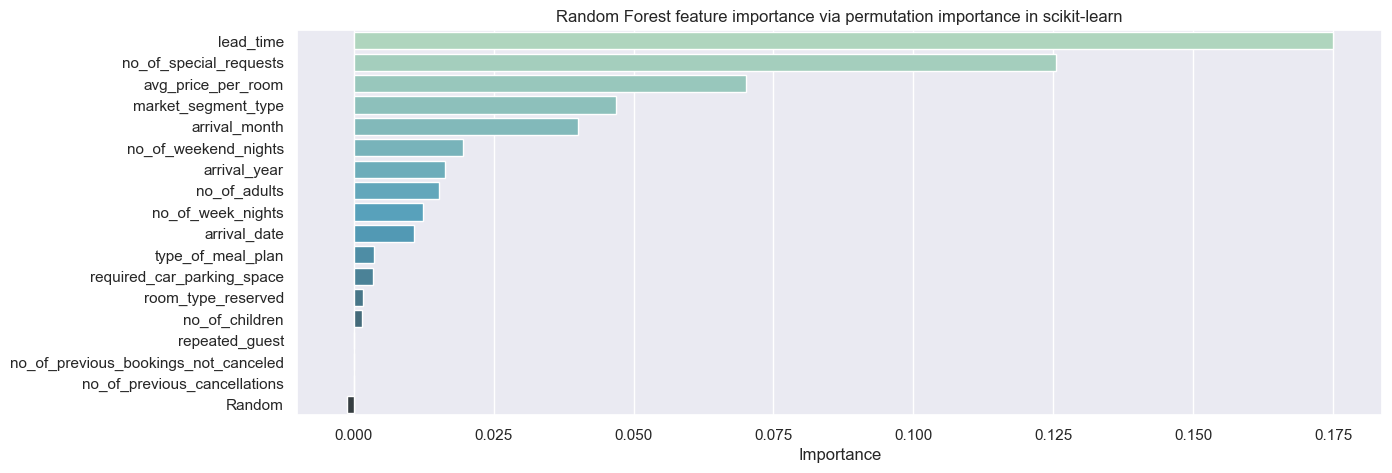

In [77]:
# Apply Permutation Importance in scikit-learn to the new datasets

# Fit the pipeline with Random Forest to the new training data
pipe_rf.fit(X_train_r,Y_train_encoded)

# Apply Permutation Importance to the pipe_rf
result2 = permutation_importance(estimator = pipe_rf,
                                 X = X_test_r,
                                 y = Y_test_encoded,
                                 scoring = 'accuracy',
                                 n_repeats = 20,
                                 random_state = 0)

# Extract the feature importances from the result
importances = result2.importances_mean

# Create df with the permutation importances
df_permimporskl_r = pd.DataFrame(result2.importances_mean,              # <---- extract the feature importances from 'result'
                                 index = X_train_r.columns,
                                 columns = ['Importance'] 
                                 )

# Sort the features according to their importance in descending order
df_permimporskl_r_sorted = df_permimporskl_r.sort_values(by = 'Importance',
                                                         ascending = False)

# Plot
plt.figure(figsize = (14,6))

sns.barplot(x = df_permimporskl_r_sorted['Importance'],
            y = df_permimporskl_r_sorted.index,
            orient = 'h',
            palette = 'GnBu_d')

plt.title('Random Forest feature importance via permutation importance in scikit-learn')

plt.show()

I observ that the extra column called `Random` have negative importance. Not in this case, but in some datasets we can consider that the features with very low importance (around the importance of `Random` feature importance) can be rule out from the "most important" features

<div style="background-color:  #ddedea; padding: 10px;">
    
### 8. Hyperterparameter tuning + Confusion matrix + Classification report + ROC-AUC curve
</div>

In [122]:
# Metrics Pkgs
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix


**Confusion matrix**

---

A confusion matrix is a table that is commonly used to evaluate the performance of a machine learning classification model. It provides a summary of the model's predictions compared to the actual known outcomes.

The confusion matrix organizes the predicted labels of the model into a matrix with rows representing the true classes and columns representing the predicted classes. It is typically a square matrix for binary classification problems but can be extended for multi-class problems.

The confusion matrix consists of four important metrics:

1. True Positives (TP): This indicates the number of samples that are correctly predicted as positive (belonging to the positive class).

2. True Negatives (TN): This indicates the number of samples that are correctly predicted as negative (belonging to the negative class).

3. False Positives (FP): This represents the number of samples that are incorrectly predicted as positive when they actually belong to the negative class (also known as a Type I error).

4. False Negatives (FN): This represents the number of samples that are incorrectly predicted as negative when they actually belong to the positive class (also known as a Type II error)


Using these metrics, various evaluation metrics can be derived from the confusion matrix, including accuracy, precision, recall (or sensitivity), specificity, and F1 score.

**ROC curve and ROC-AUC score**

---


**ROC-AUC curve**

The ROC-AUC curve and the ROC score are commonly used metrics to evaluate the performance of binary classification models.

ROC stands for Receiver Operating Characteristic, and AUC stands for Area Under the Curve. The ROC curve is a graphical representation of the classifier's performance as the discrimination threshold is varied. It plots the True Positive Rate (TPR) on the y-axis against the False Positive Rate (FPR) on the x-axis. The curve shows how well the model can distinguish between the positive and negative classes across various threshold values.

**AUC score**

The AUC score represents the area under the ROC curve. It summarizes the classifier's overall performance and ranges from 0 to 1, where a score of 1 indicates a perfect classifier, and a score of 0.5 suggests that the classifier performs no better than random guessing.

A classifier with a higher AUC score and a curve closer to the top-left corner of the plot generally indicates better performance, as it indicates higher TPR values for a given FPR.

In [105]:
# Create the table with summary of metrics per model
models_summary = {}

# Create the list with the models (with Grid Search) names
models_GS = []
models_GBNames = []

<div style="background-color:  #c6e2e9; padding: 10px;"> 
    
 **XGBoost**
    
</div>  

Hyperparameters I plan to tune:

- `max_depth`: The maximum depth per tree. A deeper tree might increase the performance, but also the complexity and chances to overfit. **The value must be an integer greater than 0. Default is 6.**

- `learning_rate`: The learning rate determines the step size at each iteration while your model optimizes toward its objective. A low learning rate makes computation slower, and requires more rounds to achieve the same reduction in residual error as a model with a high learning rate. But it optimizes the chances to reach the best optimum. **The value must be between 0 and 1. Default is 0.3.**

- `n_estimators`: The number of trees in our ensemble. Equivalent to the number of boosting rounds. **The value must be an integer greater than 0. Default is 100.**

- `colsample_bytree`: Represents the fraction of columns to be randomly sampled for each tree. It might improve overfitting. **The value must be between 0 and 1. Default is 1.**

- `subsample`: Represents the fraction of observations to be sampled for each tree. A lower values prevent overfitting but might lead to under-fitting. **The value must be between 0 and 1. Default is 1.**

Regularizations parameters:

- `alpha (reg_alpha)`: L1 regularization on the weights (Lasso Regression). When working with a large number of features, it might improve speed performances. It can be any integer. **Default is 0.**

- `lambda (reg_lambda)`: L2 regularization on the weights (Ridge Regression). It might help to reduce overfitting. It can be any integer. **Default is 1.**

- `gamma`: Gamma is a pseudo-regularisation parameter (Lagrangian multiplier), and depends on the other parameters. The higher Gamma is, the higher the regularization. It can be any integer. **Default is 0**, meaning that there is no regularization.

In [97]:
# Train and test data with the features selected by SFS
X_train_xgb = X_train[['no_of_adults', 
                       'no_of_children', 
                       'no_of_weekend_nights', 
                       'no_of_week_nights', 
                       'lead_time', 
                       'arrival_year', 
                       'arrival_month', 
                       'arrival_date', 
                       'no_of_previous_cancellations', 
                       'no_of_previous_bookings_not_canceled', 
                       'avg_price_per_room', 
                       'no_of_special_requests', 
                       'type_of_meal_plan', 
                       'required_car_parking_space', 
                       'room_type_reserved', 
                       'market_segment_type']]

X_test_xgb = X_test[['no_of_adults', 
                     'no_of_children', 
                     'no_of_weekend_nights', 
                     'no_of_week_nights', 
                     'lead_time', 
                     'arrival_year', 
                     'arrival_month', 
                     'arrival_date', 
                     'no_of_previous_cancellations', 
                     'no_of_previous_bookings_not_canceled', 
                     'avg_price_per_room', 
                     'no_of_special_requests', 
                     'type_of_meal_plan', 
                     'required_car_parking_space', 
                     'room_type_reserved', 
                     'market_segment_type']]

Applying GridSearchCV

In [155]:
# Instantiate the pipeline
pipe_xgbGrid = Pipeline([('sampler', sampler),
                         ('XGBoost', XGBClassifier())]) 

# Define grid space for the parameters of XGB
search_space_xgb = [{'XGBoost__max_depth': [3, 6, 8, 10],                            # <--- next add 10
                     'XGBoost__learning_rate': [0.01, 0.05, 0.1],                 # <--- next add 0.1
                     'XGBoost__n_estimators': [100, 500, 700],              # <--- high values leads to overfitting       
                     'XGBoost__colsample_bytree': [0.1, 0.2, 0.3]}]         # <--- high values leads to overfitting 

# Instantiate the Grid Search
model_xgbGrid = GridSearchCV(estimator = pipe_xgbGrid,
                             param_grid = search_space_xgb,
                             scoring = 'accuracy',
                             cv = 3,
                             n_jobs = -1)

# Fit the model in the Grid Search to the train data 
model_xgbGrid.fit(X_train_xgb, Y_train_encoded)

# Add the model with Grid Search already fitted to 'models_GS'
models_GS.append(model_xgbGrid)
models_GBNames.append('XGBoost')

# ---------------------------------------------------------------------------------
# Print some important values
print('Best parameters:', model_xgbGrid.best_params_)
print('\n')
print('Best estimator found in the Grid Search:', model_xgbGrid.best_estimator_)
print('\n')
print('Accuracy of the best estimator:', model_xgbGrid.best_score_)
print('\n')

print('XGBoost (with Grid Search) \n -------------------------------------------------------------')
print("Training accuracy for {}: {}".format('XGBoost', np.mean(model_xgbGrid.predict(X_train_xgb) == Y_train_encoded)*100))
print ('Test accuracy for {}: {}'.format('XGBoost', np.mean(model_xgbGrid.predict(X_test_xgb) == Y_test_encoded)*100))

Best parameters: {'XGBoost__colsample_bytree': 0.3, 'XGBoost__learning_rate': 0.1, 'XGBoost__max_depth': 8, 'XGBoost__n_estimators': 500}


Best estimator found in the Grid Search: Pipeline(steps=[('sampler', SMOTE(random_state=42)),
                ('XGBoost',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.3, early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=8, max_leaves

Classification Report for XGBoost 
-------------------------------------
              precision    recall  f1-score   support

Not_Canceled       0.85      0.80      0.82      2416
    Canceled       0.90      0.93      0.92      4839

    accuracy                           0.89      7255
   macro avg       0.87      0.86      0.87      7255
weighted avg       0.88      0.89      0.88      7255

AUC Score 0.8644980542337437


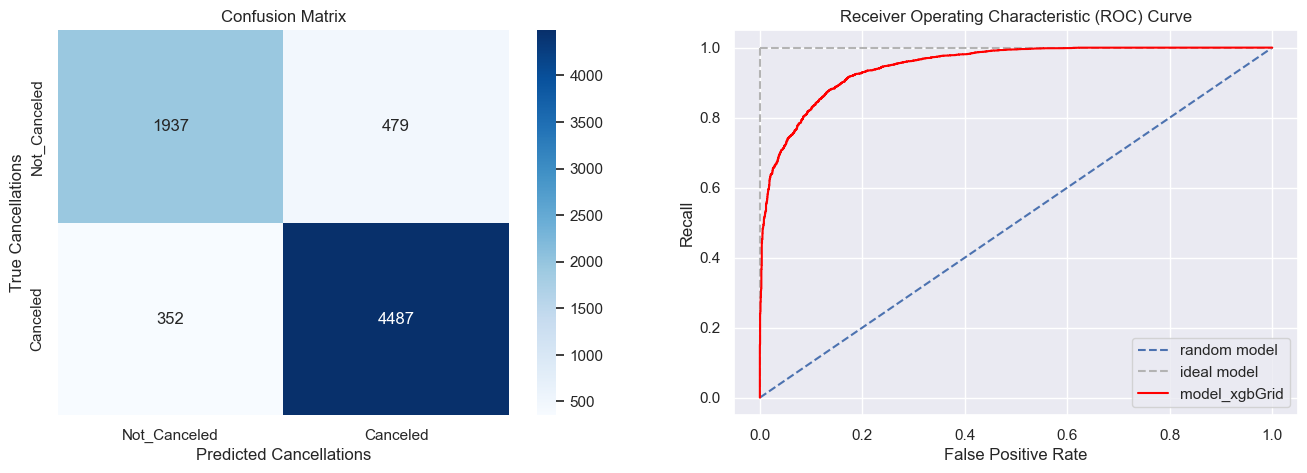

In [159]:
# Generate the classification report
print("Classification Report for XGBoost \n-------------------------------------")
print(classification_report(Y_test_encoded, 
                            model_xgbGrid.predict(X_test_xgb), 
                            target_names = ['Not_Canceled', 'Canceled'])
     )


# ---------------------------------------------------------------------------
# Confusion Matrix
df_confmatrix = confusion_matrix(Y_test_encoded, 
                                 model_xgbGrid.predict(X_test_xgb))
fig, ax = plt.subplots(ncols = 2,
                       figsize = (16,5))

sns.heatmap(df_confmatrix, 
            annot=True, 
            fmt='d', 
            cmap='Blues',
            xticklabels = ['Not_Canceled', 'Canceled'],
            yticklabels = ['Not_Canceled', 'Canceled'],
            ax = ax[0])

ax[0].set(title = 'Confusion Matrix',
          xlabel = 'Predicted Cancellations',
          ylabel = 'True Cancellations')

# ---------------------------------------------------------------------------
# ROC-AUC Curve

# 1. Calculate the probabilities of positive class (Not_Canceled in this case)
model_xgbGrid_pred_prob = model_xgbGrid.predict_proba(X_test_xgb)[:, 1]

# 2. Calculate the ROC curve values: the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(Y_test_encoded, 
                                 model_xgbGrid_pred_prob,
                                 drop_intermediate = False)

# 3. Calculate the AUC score
auc_xgbGrid = roc_auc_score(Y_test_encoded, model_xgbGrid.predict(X_test_xgb))
print('AUC Score', auc_xgbGrid)

# 4. Plot the ROC curve

# reference lines
ax[1].plot([0, 1], ls = "--", label='random model')                     # <---- blue diagonal
ax[1].plot([0, 0], [1, 0], c=".7", ls='--', label='ideal model')        # <---- grey vertical
ax[1].plot([1, 1], c=".7", ls='--')                                     # <---- grey horizontal

ax[1].plot(fpr, tpr, color = 'red', label='model_xgbGrid')    # <---- roc curve

# labels
ax[1].set(title = 'Receiver Operating Characteristic (ROC) Curve',
          xlabel = 'False Positive Rate',
          ylabel = 'Recall')

ax[1].legend();

plt.show()

<div style="background-color:  #c6e2e9; padding: 10px;">

 **Random Forest**

</div>

Hyperparameters I plan to tune:

- `max_depth`: The maximum depth per tree. A deeper tree might increase the performance, but also the complexity and chances to overfit. **The value must be an integer greater than 0. Default is 6.**

- `min_samples_leaf`: Minimum number of observations that need to be in the terminal nodes (leafs)

- `n_estimators`: The number of trees in our ensemble. **The value must be an integer greater than 0. Default is 100.**

In [37]:
display(df_rfimportance_sorted)


,Importance
lead_time,0.296882
avg_price_per_room,0.146746
no_of_special_requests,0.116780
arrival_month,0.094774
arrival_date,0.090648
no_of_week_nights,0.067739
market_segment_type,0.048857
no_of_weekend_nights,0.040148
arrival_year,0.027496
no_of_adults,0.023714


,Importance
no_of_adults,0.023714
no_of_children,0.008727
no_of_weekend_nights,0.040148
no_of_week_nights,0.067739
lead_time,0.296882
arrival_year,0.027496
arrival_month,0.094774
arrival_date,0.090648
no_of_previous_cancellations,0.000380
no_of_previous_bookings_not_canceled,0.002113


**Summary of Results per Model**

In [157]:
# Add all models with metrics to 'models_summary'
for i, model in enumerate(models_GS):
    
    models_summary[f'{models_GBNames[i]}'] = [accuracy_score(model.predict(X_test_xgb), Y_test_encoded),
                                              f1_score(model.predict(X_test_xgb), Y_test_encoded),
                                              precision_score(model.predict(X_test_xgb), Y_test_encoded),
                                              recall_score(model.predict(X_test_xgb), Y_test_encoded)]
    


In [158]:
#  Create the dataframe with 'models_summary'
df_models_summary = pd.DataFrame(models_summary).T

# Define the columns names
df_models_summary.columns = ['Accuracy', 'F1-Score', 'Precision', 'Recall']

# Highlight the highest metric values in 'df_models_summary'
df_models_summary = df_models_summary.sort_values(by = 'F1-Score', ascending = False)    # <---- Sorting by f1-score 
df_models_summary.style.format("{:.2%}").background_gradient(cmap="Blues")               # <---- Setting the colors

display(models_summary)
display(df_models_summary)

{'XGBoost': [0.8854583046175052,
  0.9152473227944926,
  0.9272576978714611,
  0.9035440998791784]}

,Accuracy,F1-Score,Precision,Recall
XGBoost,0.885458,0.915247,0.927258,0.903544
